In [2]:
# flake8: noqa: E302

import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")


file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

# %%
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels


# Example usage
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

# %%
# Reshape the datasets from 3D to 2D
train_images_2d = train_images.reshape(
    train_images.shape[0], -1
)  # -1 infers the size from the remaining dimensions
test_images_2d = test_images.reshape(test_images.shape[0], -1)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.
Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


## Transofrming image to binary

In [3]:
# Thresholding
train_images_binary = np.where(train_images_2d > 127, 1, 0)
test_images_binary = np.where(test_images_2d > 127, 1, 0)

# Check the shape and unique values to confirm the conversion
print(train_images_binary.shape)
print(np.unique(train_images_binary))
print(test_images_binary.shape)
print(np.unique(test_images_binary))

(60000, 784)
[0 1]
(10000, 784)
[0 1]


## Continue as normal

In [4]:
import numpy as np


def get_bounding_box(img):
    """
    Extract the bounding box from an MNIST image.

    Args:
        img (np.ndarray): 2D numpy array representing the MNIST image.

    Returns:
        (np.ndarray): Cropped image with the bounding box.
    """

    # Find the rows and columns where the image has non-zero pixels
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    # Find the first and last row and column indices where the image has non-zero pixels
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Return the cropped image
    return img[rmin : rmax + 1, cmin : cmax + 1]

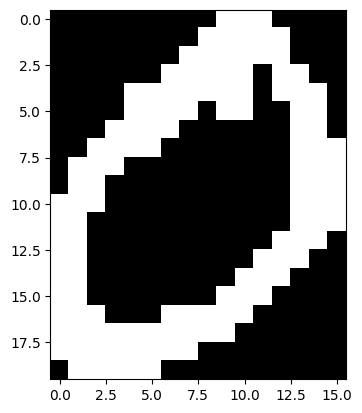

Image shape (20, 16)
Label 0


In [5]:
image_id = 1

image = train_images_binary[image_id].reshape(28, 28)
cropped_image = get_bounding_box(image)

import matplotlib.pyplot as plt

plt.imshow(cropped_image, cmap="gray")
plt.show()

print("Image shape", cropped_image.shape)

print("Label", train_labels[image_id])

In [6]:
import cv2

cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
resized_image = cv2.resize(cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA)

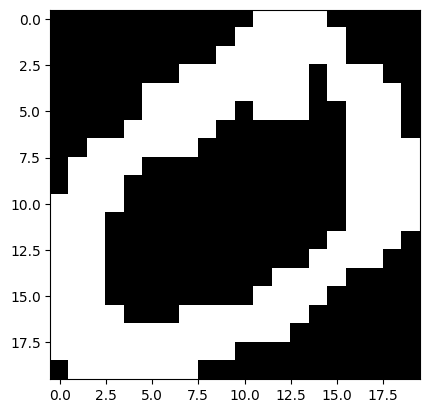

Image shape (20, 20)
Label 0


In [7]:
image_id = 1

plt.imshow(resized_image, cmap="gray")
plt.show()

print("Image shape", resized_image.shape)

print("Label", train_labels[image_id])

## Create and use dataset

In [8]:
num_train = len(train_images_binary)

train_features = np.zeros((num_train, 400))

for i in range(num_train):
    cropped_image = get_bounding_box(train_images_binary[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    train_features[i, :] = resized_image.flatten()

num_test = len(test_images_binary)

test_features = np.zeros((num_test, 400))

for i in range(num_test):
    cropped_image = get_bounding_box(test_images_binary[i].reshape(28, 28))
    cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
    resized_image = cv2.resize(
        cropped_image_uint8, (20, 20), interpolation=cv2.INTER_AREA
    )
    test_features[i, :] = resized_image.flatten()

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Create and train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(train_features, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [10]:
num_test_samples = len(test_features)
python_predictions = clf.predict(test_features)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

Python accuracy: 83.7 %


## Try out an SVM

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features)

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel="rbf", random_state=0, C=1000)
clf.fit(train_features_normalized, train_labels)

In [ ]:
num_test_samples = len(test_features_normalized)
python_predictions = clf.predict(test_features_normalized)
python_accuracy = np.sum(python_predictions == test_labels) / num_test_samples
print(f"Python accuracy: {100*python_accuracy} %")

print("Number of support vectors", clf.n_support_)
print("Total number of support vectors", sum(clf.n_support_))

## Try out an MLP neural network

In [11]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# Define and initialize the MLP classifier
mlp_large = MLPClassifier(
    hidden_layer_sizes=(205,), max_iter=30, alpha=0.0001, solver="adam", random_state=0
)
mlp_large.fit(train_features_normalized, train_labels)

In [ ]:
# Evaluate the classifier
accuracy = mlp_large.score(test_features_normalized, test_labels)
print("Accuracy:", accuracy)

layers_sizes = [mlp_large.coefs_[0].shape[0]] + [
    coef.shape[1] for coef in mlp_large.coefs_
]

print("Number of neurons per layer:", layers_sizes)

## Try out a smaller network

In [18]:
# Define and initialize the MLP classifier
clf = MLPClassifier(
    hidden_layer_sizes=(24,), max_iter=30, alpha=0.0001, solver="adam", random_state=0
)
clf.fit(train_features_normalized, train_labels)

/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(24,), max_iter=30, random_state=0)

In [19]:
# Evaluate the classifier
accuracy = clf.score(test_features_normalized, test_labels)
print("Accuracy:", accuracy)

layers_sizes = [clf.coefs_[0].shape[0]] + [coef.shape[1] for coef in clf.coefs_]

print("Number of neurons per layer:", layers_sizes)

Accuracy: 0.9511
Number of neurons per layer: [400, 24, 10]


## Try out pruning

In [20]:
import copy

from helper import prune_neural_network

pruned_network = copy.deepcopy(clf)
pruned_network = prune_neural_network(pruned_network, 1e-1, 1e-1)

Number of weight parameters: 9840
Number of changed weight parameters: 5013
Number of bias parameters: 34
Number of changed bias parameters: 9
Percentage of weights pruned: 50.95%
Percentage of biases pruned: 26.47%
Remaining number of non-zero weights: 4827
Remaining number of non-zero biases: 25


In [21]:
# Evaluate the classifier
accuracy = pruned_network.score(test_features_normalized, test_labels)
print("Accuracy:", accuracy)

layers_sizes = [pruned_network.coefs_[0].shape[0]] + [
    coef.shape[1] for coef in pruned_network.coefs_
]

print("Number of neurons per layer:", layers_sizes)

Accuracy: 0.9432
Number of neurons per layer: [400, 24, 10]


## Prune the larger network

In [ ]:
pruned_network = copy.deepcopy(mlp_large)
pruned_network = prune_neural_network(pruned_network, 1e-1, 1e-1)

In [ ]:
# Evaluate the classifier
accuracy = pruned_network.score(test_features_normalized, test_labels)
print("Accuracy:", accuracy)

layers_sizes = [pruned_network.coefs_[0].shape[0]] + [
    coef.shape[1] for coef in pruned_network.coefs_
]

print("Number of neurons per layer:", layers_sizes)

## Let's try to train the network with L1 regularization to make it more sparse and prune it further, using PyTorch

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Convert your dataset to PyTorch tensors
train_features_tensor = torch.tensor(train_features_normalized, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features_normalized, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Define the PyTorch neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Hyperparameters
input_dim = train_features_normalized.shape[1]
hidden_dim = 70
output_dim = len(set(train_labels))  # Assuming train_labels are class indices

# Instantiate the model
model = SimpleNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_features_tensor)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(test_features_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print("Accuracy:", accuracy)

Epoch [100/1000], Loss: 0.3273
Epoch [200/1000], Loss: 0.2534
Epoch [300/1000], Loss: 0.2136
Epoch [400/1000], Loss: 0.1875
Epoch [500/1000], Loss: 0.1691
Epoch [600/1000], Loss: 0.1557
Epoch [700/1000], Loss: 0.1453
Epoch [800/1000], Loss: 0.1371
Epoch [900/1000], Loss: 0.1305
Epoch [1000/1000], Loss: 0.1250
Accuracy: 0.9709


In [29]:
import copy

from helper import prune_pytorch_network

pruned_network = copy.deepcopy(model)
pruned_network = prune_pytorch_network(pruned_network, 1e-1, 1e-1)

Number of weight parameters: 28700
Number of changed weight parameters: 26405
Number of bias parameters: 80
Number of changed bias parameters: 61
Percentage of weights pruned: 92.00%
Percentage of biases pruned: 76.25%
Remaining number of non-zero weights: 2295
Remaining number of non-zero biases: 19


In [30]:
# Evaluation
pruned_network.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = pruned_network(test_features_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print("Accuracy:", accuracy)

Accuracy: 0.7851


In [34]:
pruned_network.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pruned_network.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient
num_epochs = 100

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = pruned_network(train_features_tensor)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in pruned_network.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.2111
Epoch [20/100], Loss: 0.1763
Epoch [30/100], Loss: 0.1605
Epoch [40/100], Loss: 0.1517
Epoch [50/100], Loss: 0.1459
Epoch [60/100], Loss: 0.1419
Epoch [70/100], Loss: 0.1389
Epoch [80/100], Loss: 0.1364
Epoch [90/100], Loss: 0.1343
Epoch [100/100], Loss: 0.1325


In [35]:
# Evaluation
pruned_network.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = pruned_network(test_features_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print("Accuracy:", accuracy)

Accuracy: 0.9694


In [40]:
pruned_network2 = copy.deepcopy(pruned_network)
pruned_network2 = prune_pytorch_network(pruned_network2, 1e-1, 1e-1)

Number of weight parameters: 28700
Number of changed weight parameters: 26444
Number of bias parameters: 80
Number of changed bias parameters: 63
Percentage of weights pruned: 92.14%
Percentage of biases pruned: 78.75%
Remaining number of non-zero weights: 2256
Remaining number of non-zero biases: 17


In [41]:
# Evaluation
pruned_network2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = pruned_network2(test_features_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print("Accuracy:", accuracy)

Accuracy: 0.8651


## Try out Haar features in smaller images

In [42]:
def compute_haar_features(image):
    if image.shape != (20, 20):
        raise ValueError("Input image must be of shape 28x28.")

    features = []

    # Sliding window
    for i in range(0, 20, 3):  # Slide vertically with a step of 3
        for j in range(0, 20, 3):  # Slide horizontally with a step of 3

            if i + 6 > 20 or j + 6 > 20:
                continue

            # Extract 6x6 window
            window = image[i : i + 6, j : j + 6]

            # Horizontal feature
            horizontal_feature_value = np.sum(window[0:3, :]) - np.sum(window[3:6, :])

            # Vertical feature
            vertical_feature_value = np.sum(window[:, 0:3]) - np.sum(window[:, 3:6])

            features.append(horizontal_feature_value)
            features.append(vertical_feature_value)

    return features

In [43]:
haar_1 = compute_haar_features(train_features[0].reshape(20, 20))
print(haar_1)
len_haar_features = len(haar_1)
print("length of a haar feature", len_haar_features)

[-1.0, -5.0, -3.0, -7.0, -1.0, 1.0, 4.0, 0.0, 8.0, 6.0, 3.0, -3.0, 7.0, -7.0, 2.0, -2.0, 1.0, 7.0, 3.0, 5.0, 0.0, 0.0, 3.0, -3.0, 9.0, -5.0, 1.0, 1.0, -8.0, 4.0, 0.0, 0.0, 0.0, 0.0, -2.0, -4.0, -3.0, -9.0, -4.0, 4.0, -3.0, -3.0, -10.0, -4.0, -12.0, -4.0, -2.0, 0.0, 9.0, 5.0]
length of a haar feature 50


In [44]:
# compute datasets

num_train = len(train_features)
num_test = len(test_features)

haar_train = np.zeros((num_train, len_haar_features))
haar_test = np.zeros((num_test, len_haar_features))

for i in range(num_train):
    haar_train[i] = compute_haar_features(train_features[i].reshape(20, 20))

for i in range(num_test):
    haar_test[i] = compute_haar_features(test_features[i].reshape(20, 20))

In [45]:
train_features_normalized = scaler.fit_transform(haar_train)
test_features_normalized = scaler.transform(haar_test)

In [48]:
train_features_tensor = torch.tensor(train_features_normalized, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features_normalized, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Hyperparameters
input_dim = train_features_normalized.shape[1]
hidden_dim = 30
output_dim = len(set(train_labels))  # Assuming train_labels are class indices

# Instantiate the model
model = SimpleNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with L1 regularization
lambda_l1 = 0.0001  # L1 regularization coefficient
num_epochs = 1500

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_features_tensor)

    loss = criterion(outputs, train_labels_tensor)

    # Add L1 regularization
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    loss += lambda_l1 * l1_reg

    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(test_features_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print("Accuracy:", accuracy)

Epoch [100/1500], Loss: 1.1780
Epoch [200/1500], Loss: 0.6537
Epoch [300/1500], Loss: 0.4858
Epoch [400/1500], Loss: 0.4064
Epoch [500/1500], Loss: 0.3591
Epoch [600/1500], Loss: 0.3282
Epoch [700/1500], Loss: 0.3071
Epoch [800/1500], Loss: 0.2921
Epoch [900/1500], Loss: 0.2805
Epoch [1000/1500], Loss: 0.2712
Epoch [1100/1500], Loss: 0.2633
Epoch [1200/1500], Loss: 0.2564
Epoch [1300/1500], Loss: 0.2504
Epoch [1400/1500], Loss: 0.2450
Epoch [1500/1500], Loss: 0.2404
Accuracy: 0.9448


In [51]:
pruned_network = copy.deepcopy(model)
pruned_network = prune_pytorch_network(pruned_network, 1e-1, 1e-1)

Number of weight parameters: 1800
Number of changed weight parameters: 560
Number of bias parameters: 40
Number of changed bias parameters: 11
Percentage of weights pruned: 31.11%
Percentage of biases pruned: 27.50%
Remaining number of non-zero weights: 1240
Remaining number of non-zero biases: 29


In [52]:
# Evaluation
pruned_network.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = pruned_network(test_features_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print("Accuracy:", accuracy)

Accuracy: 0.94
